## Warehouse test

In [1]:
import os
import numpy as np
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures
import ollama
from collections import defaultdict

In [2]:
with open('./test_set/{}_{}agents.pth'.format('den312d', 4), 'rb') as f:
    tests = pickle.load(f)

In [3]:
# negotiator를 구성하기 위한 union find 알고리즘
def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]


def determine_direction(x, y, x_finish, y_finish):

    dx = int(x_finish) - x
    dy = int(y_finish) - y
    
    if dx > 0 and dy > 0:
        return "northeast"
    elif dx > 0 and dy < 0:
        return "southeast"
    elif dx < 0 and dy > 0:
        return "northwest"
    elif dx < 0 and dy < 0:
        return "southwest"
    elif dx > 0 and dy == 0:
        return "east"
    elif dx < 0 and dy == 0:
        return "west"
    elif dx == 0 and dy > 0:
        return "north"
    elif dx == 0 and dy < 0:
        return "south"
    else:
        return "same location"


# 방향 정의
directiondict = {
    'stay': 0, 'north': 1, 'south': 2, 'west': 3, 'east': 4
}

In [4]:
# 프롬프트
class gpt4pathfinding:
    def navigate(self, agent, heuristic_direction, east, west, north, south):
        response = ollama.generate(
        model="llama3",
        prompt=f"""
                <s>[INST] <<SYS>>
                You're a directional path finder - you know which path to take to reach your goal.
                <</SYS>>
                You can only make one move at a time.
                Your actions have 4 options: east, west, south, north.
                
                {east}
                {west}
                {south}
                {north}

                Your heuristic map says going {heuristic_direction} will shorten the distance to the destination without any possibility of dead ends.
                
                You decide which direction to move next.

                Below are examples of answers.
                Answer with only one word.

                EXAMPLE 1

                south

                EXAMPLE 2

                north
                [/INST]
                """
        )
        return agent, response['response'].lower()
    
    def give_way(self, east, west, north, south, prioragentdirection, goaldirection):
        response = ollama.generate(
        model="llama3",
        prompt=f"""
                <s>[INST] <<SYS>>
                You're a directional path finder - you know which path to take to reach your goal.
                <</SYS>>

                The position of the prior path finder is {prioragentdirection} relative to you.

                You MUST avoid collisions with prior path finder.

                Your actions have five options: east, west, south, north, and stay.

                {east}
                {west}
                {south}
                {north}

                It is recommended to move away from the prior agent.
                It is recommended to going to the 90-degree turn rather than the other side of the prior pathfinder, but you can ignore this instruction depending on your situation.

                1. You decide which direction to move next.

                Below are examples of answers.
                Answer with only one word.

                EXAMPLE 1

                south

                EXAMPLE 2

                north
                """
        )
        return response['response'].lower()
    
pathfinder = gpt4pathfinding()

In [5]:
def run_one_example(example, max_steps):

  num_agents = len(example[1])
  map_width = len(example[0]) - 1

  env = Environment()
  env.load(np.array(example[0]), np.array(example[1]), np.array(example[2]))

  def parameter_navigate(i, end_state):

    observe = env.observe()

    a_obs = observe[0][i][1]

    if a_obs[4][3] == 0:
      west = """To your west lies a path."""
    else:
      west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
      east = """To your east lies a path."""
    else:
      east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
      south = """To your south lies a path."""
    else:
      south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
      north = """To your north lies a path."""
    else:
      north = """Your north is blocked by a wall."""

    if observe[0][i][0][4][3]-1 != -1 and end_state[observe[0][i][0][4][3]-1] == 1:
      west = """Your west is blocked by a wall."""

    if observe[0][i][0][4][5]-1 != -1 and end_state[observe[0][i][0][4][5]-1] == 1:
      east = """Your east is blocked by a wall."""

    if observe[0][i][0][5][4]-1 != -1 and end_state[observe[0][i][0][5][4]-1] == 1:
      south = """Your south is blocked by a wall."""

    if observe[0][i][0][3][4]-1 != -1 and end_state[observe[0][i][0][3][4]-1] == 1:
      north = """Your north is blocked by a wall."""

    directions = []

    if env.observe()[0][i][2][4, 4] == 1:
      directions.append('north')
    if env.observe()[0][i][3][4, 4] == 1:
      directions.append('south')
    if env.observe()[0][i][4][4, 4] == 1:
      directions.append('west')
    if env.observe()[0][i][5][4, 4] == 1:
      directions.append('east')
    
    heuristic_direction = ' and '.join(directions)

    return heuristic_direction, east, west, north, south
  
  def parameter_give_way(i, end_state):

    observe = env.observe()

    a_obs = observe[0][i][1]
    x = observe[1][i][1]
    y = map_width-observe[1][i][0]
    x_finish = example[2][i][1]
    y_finish = map_width-example[2][i][0]
    goaldirection = determine_direction(x, y, x_finish, y_finish)

    if a_obs[4][3] == 0:
        west = """To your west lies a path."""
    else:
        west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
        east = """To your east lies a path."""
    else:
        east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
        south = """To your south lies a path."""
    else:
        south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
        north = """To your north lies a path."""
    else:
        north = """Your north is blocked by a wall."""

    if observe[0][i][0][4][3]-1 != -1 and end_state[observe[0][i][0][4][3]-1] == 1:
      west = """Your west is blocked by a wall."""

    if observe[0][i][0][4][5]-1 != -1 and end_state[observe[0][i][0][4][5]-1] == 1:
      east = """Your east is blocked by a wall."""

    if observe[0][i][0][5][4]-1 != -1 and end_state[observe[0][i][0][5][4]-1] == 1:
      south = """Your south is blocked by a wall."""

    if observe[0][i][0][3][4]-1 != -1 and end_state[observe[0][i][0][3][4]-1] == 1:
      north = """Your north is blocked by a wall."""

    # prior agent의 direction 구하기
    agent_map = env.observe()[0][i][0][2:7, 2:7]
    center = (2, 2)
    max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

    row_diff = center[0] - max_position[0]
    col_diff = center[1] - max_position[1]

    if row_diff > 0 and col_diff > 0:
        prioragentdirection = "northwest"
    elif row_diff > 0 and col_diff == 0:
        prioragentdirection = "north"
    elif row_diff > 0 and col_diff < 0:
        prioragentdirection = "northeast"
    elif row_diff == 0 and col_diff > 0:
        prioragentdirection = "west"
    elif row_diff == 0 and col_diff < 0:
        prioragentdirection = "east"
    elif row_diff < 0 and col_diff > 0:
        prioragentdirection = "southwest"
    elif row_diff < 0 and col_diff == 0:
        prioragentdirection = "south"
    elif row_diff < 0 and col_diff < 0:
        prioragentdirection = "southeast"

    return east, west, north, south, prioragentdirection, goaldirection

  
  #에이전트들의 지난번 액션들과 좌표
  action_list = [[] for _ in range(num_agents)]
  coordinate_list = [[] for _ in range(num_agents)]
  step_list = [0 for _ in range(num_agents)]
  dead_end_state = [0 for _ in range(num_agents)]
  end_state = [0 for _ in range(num_agents)]
  steps = 0

  # turn
  while steps < max_steps:

    for i in range(num_agents):
      if not np.array_equal(env.agents_pos[i], env.goals_pos[i]):
        step_list[i] += 1
      else: end_state[i] = 1

    for i in range(num_agents):
      x_coordinate = env.observe()[1][i][1]
      y_coordinate = map_width-env.observe()[1][i][0]

      coordinate_list[i].append([x_coordinate, y_coordinate])

    step = [0 for i in range(num_agents)]

    #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
    FOV_agents = []
    for i in range(num_agents):
      if np.any(env.observe()[0][i][0][2:7, 2:7]):
        non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
        non_zero_elements = [element - 1 for element in non_zero_elements]
        non_zero_elements.append(i)
        FOV_agents.append(non_zero_elements)

    #알고리즘을 이용해 연결된 집합 찾기
    connected_sets = merge_sets(FOV_agents)

    #연결이 있는 모든 에이전트들
    deadlocked_agents = [item for sublist in connected_sets for item in sublist]

    parameters = []

    for i in range(num_agents):

      if np.array_equal(env.agents_pos[i], env.goals_pos[i]):
        step[i] = directiondict['stay']
        continue  # 다음 에이전트로 넘어감

      #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
      if i not in deadlocked_agents:

        heuristic_direction, east, west, north, south = parameter_navigate(i, end_state)

        parameters.append([i, heuristic_direction, east, west, north, south])

    with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
      # 각 프롬프트에 대해 비동기 작업 제출
      futures = [executor.submit(pathfinder.navigate, parameter[0], parameter[1], parameter[2], parameter[3], parameter[4], parameter[5]) for parameter in parameters]
      
      results = []

      # 각 작업의 결과 출력
      for future in concurrent.futures.as_completed(futures):
          result = future.result()
          results.append(result)

    for (i, result) in results:
        
      direction = result

      if direction not in directiondict:
        direction = 'stay'

      step[i] = directiondict[direction]
      
    
    # 교착상태에 빠진 에이전트에 대해
    for connected_set in connected_sets:
      
      results = []

      parameters = []

      for i in connected_set: # 여기서 i는 agent의 번호들

        if np.array_equal(env.agents_pos[i], env.goals_pos[i]):
          direction = 'stay'
          results.append(direction)
          continue
      
      #각각의 에이전트에 대해 원래 계획된 경로를 계산

        heuristic_direction, east, west, north, south = parameter_navigate(i, end_state)

        _, result = pathfinder.navigate(i, heuristic_direction, east, west, north, south)

        direction = result

        if direction not in directiondict:
          direction = 'stay'

        results.append(direction)

      env_copy = copy.deepcopy(env)
      planned_step = [0 for _ in range(num_agents)]
      for idx, agent_idx in enumerate(connected_set):
        planned_step[agent_idx] = directiondict[results[idx]]
      if -0.5 in env_copy.step(planned_step)[1]:
        collision = True
      else:
        collision = False

      if not collision:
        for idx, agent_idx in enumerate(connected_set):
          action_list[agent_idx].append(results[idx])
          step[agent_idx] = directiondict[results[idx]]
      else:
      # 먼저 prior agent는 원래대로 이동하게 함
        prior_agent_number = max(connected_set)
        prior_agent_idx = connected_set.index(prior_agent_number)
        action_list[prior_agent_number].append(results[prior_agent_idx])
        step[prior_agent_number] = directiondict[results[prior_agent_idx]]
        for i in connected_set:
          if i != prior_agent_number:
              
              east, west, north, south, prioragentdirection, goaldirection = parameter_give_way(i, end_state)

              result = pathfinder.give_way(east, west, north, south, prioragentdirection, goaldirection)

              direction = result

              if direction not in directiondict:
                direction = 'stay'

              action_list[i] = []
      
              step[i] = directiondict[direction]

    for i in range(num_agents):

      if end_state[i] == 1:
        step[i] = directiondict['stay']

    observation, rewards, done, info = env.step(step)

    env.render()

    if done:
      break
    steps += 1

  return step_list

In [6]:
def simulate_all_tests(tests, max_steps):
    all_step_lists = []
    for example in tests:
        step_list = run_one_example(example, max_steps)
        all_step_lists.append(step_list)
        print(step_list)
    return all_step_lists

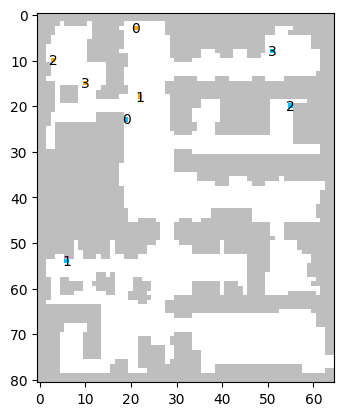

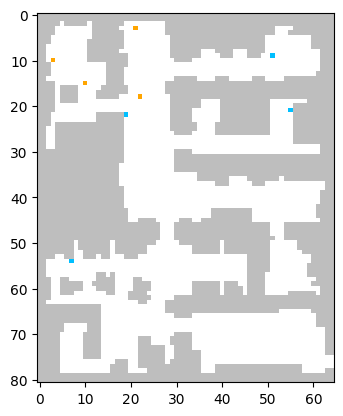

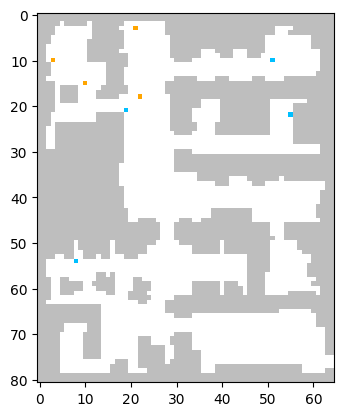

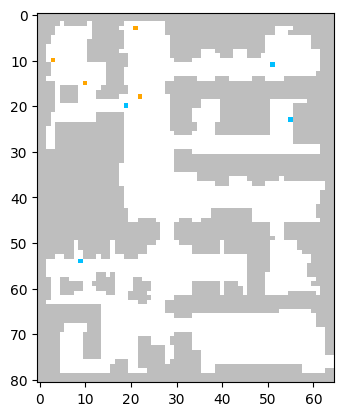

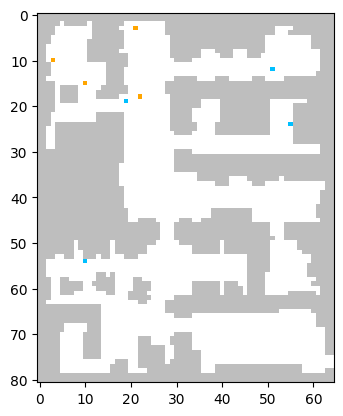

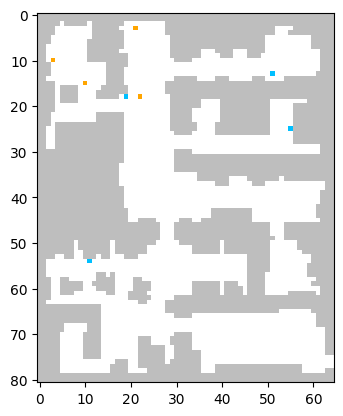

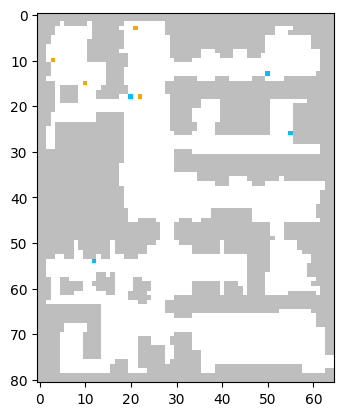

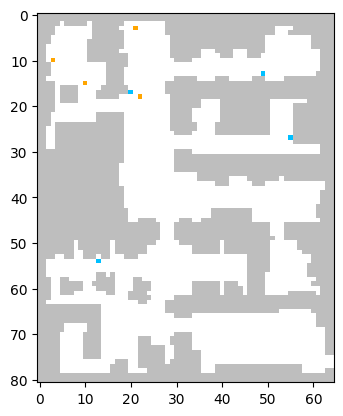

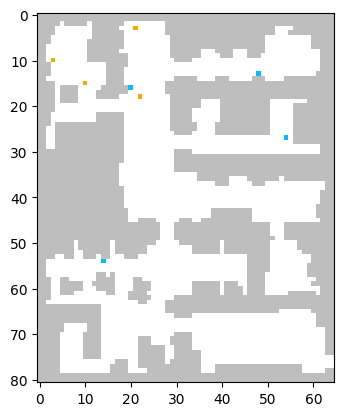

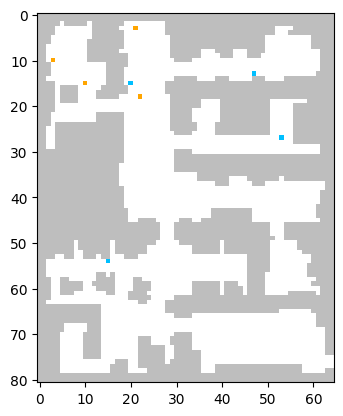

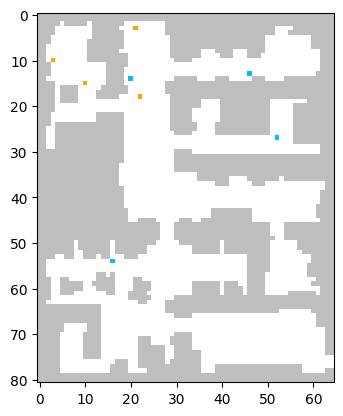

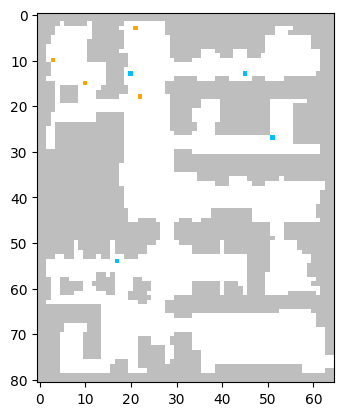

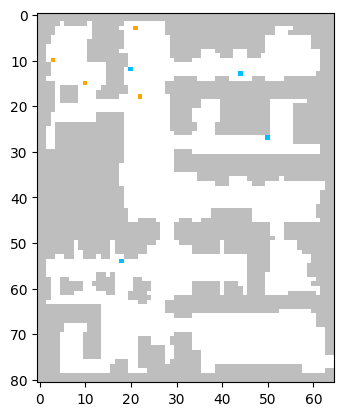

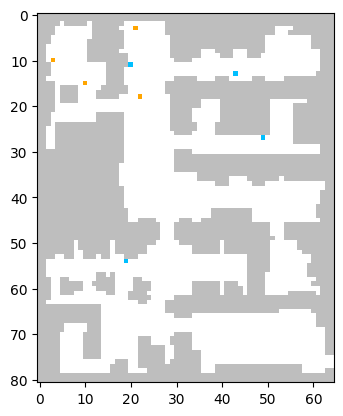

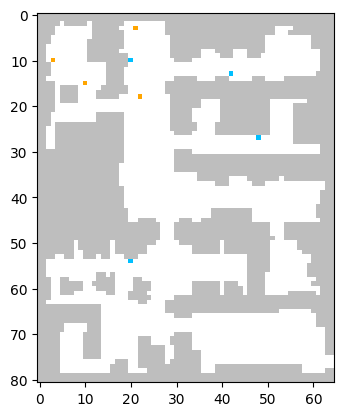

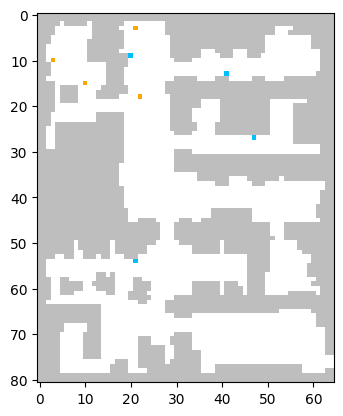

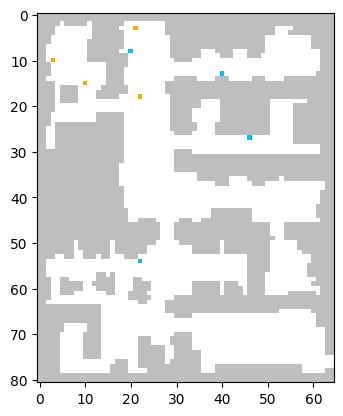

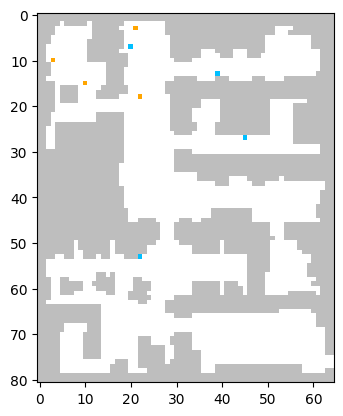

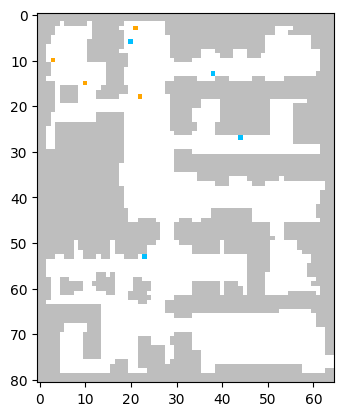

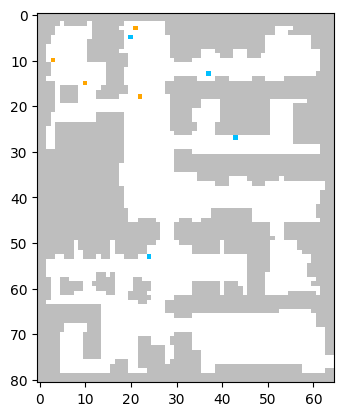

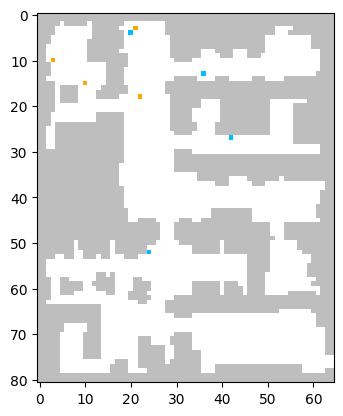

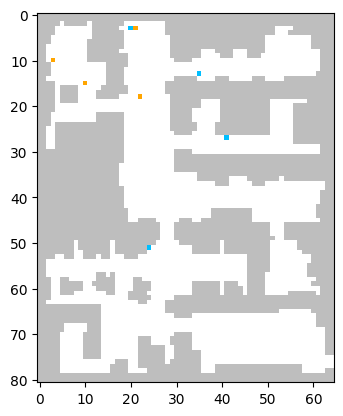

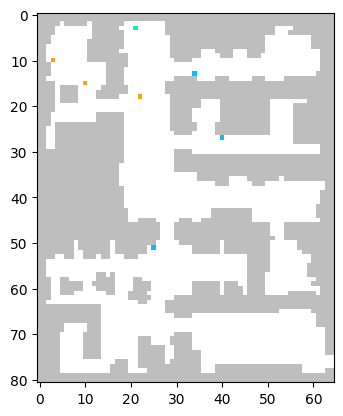

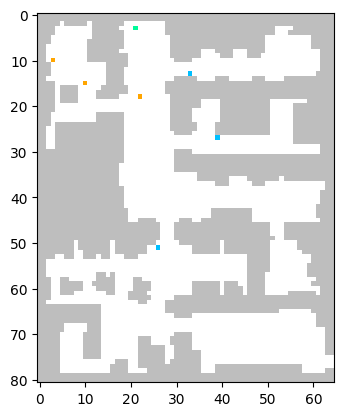

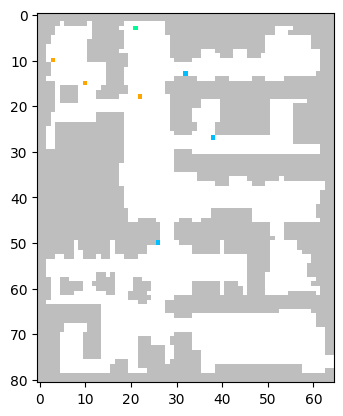

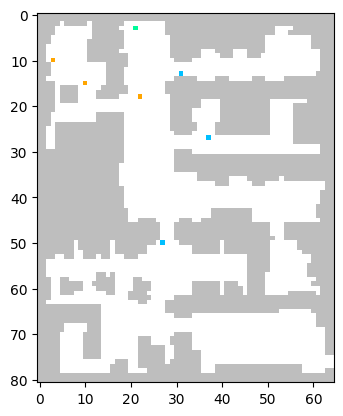

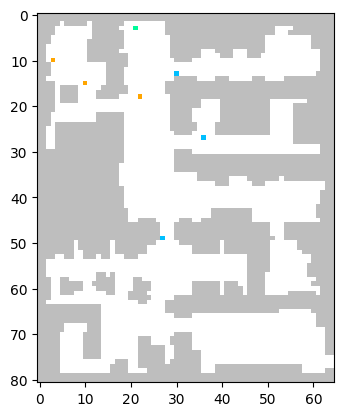

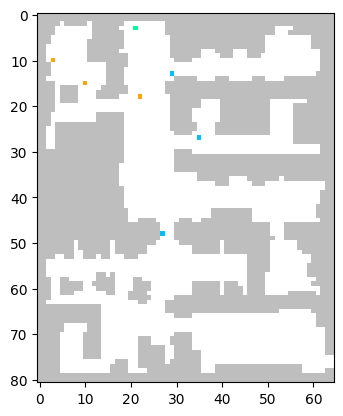

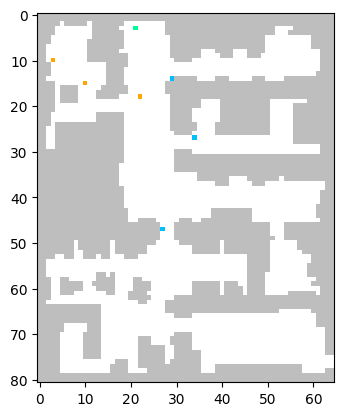

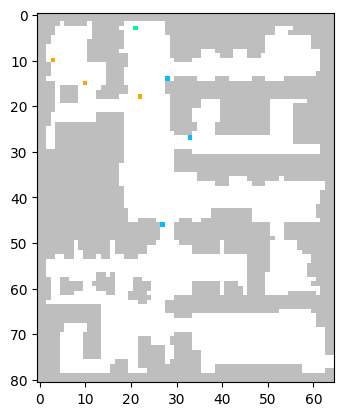

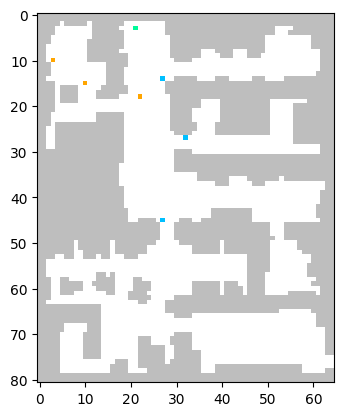

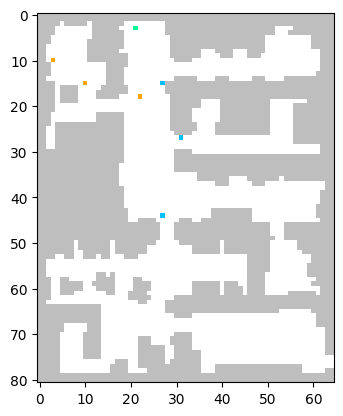

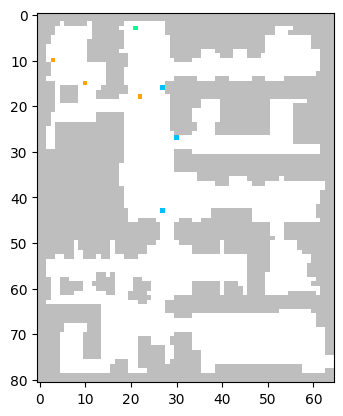

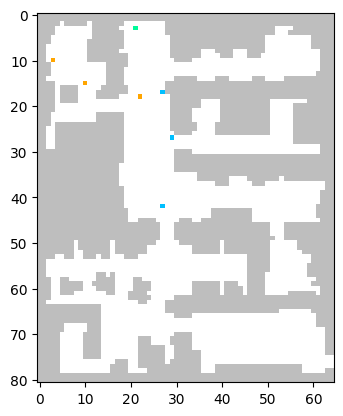

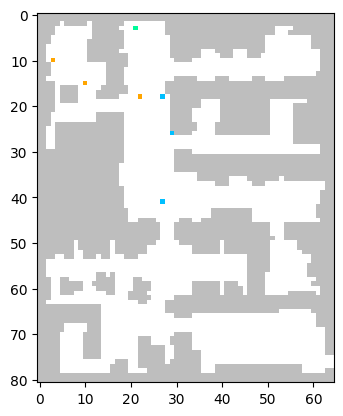

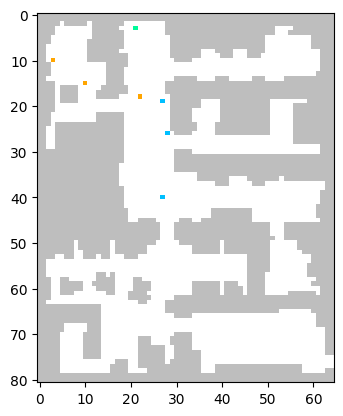

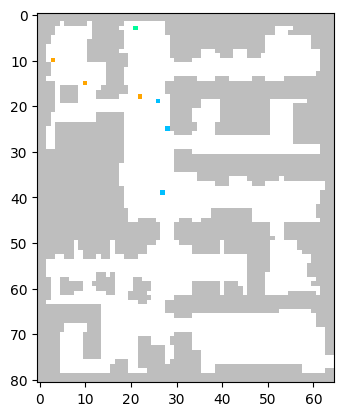

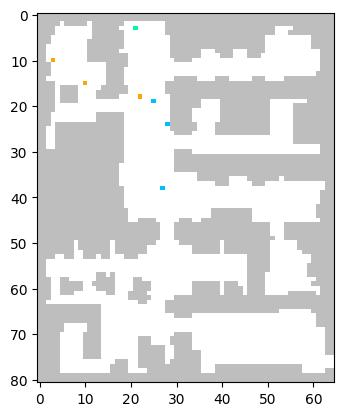

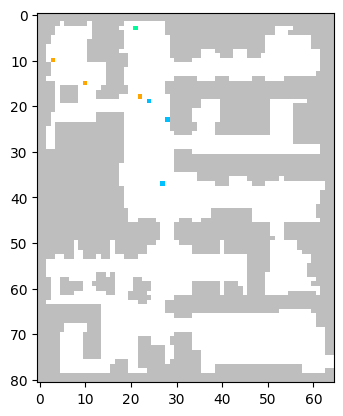

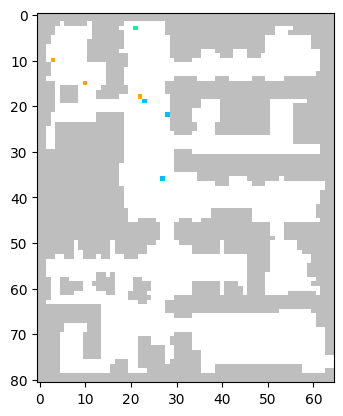

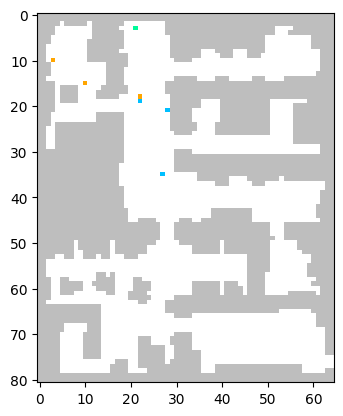

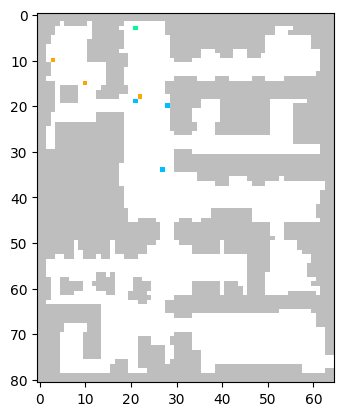

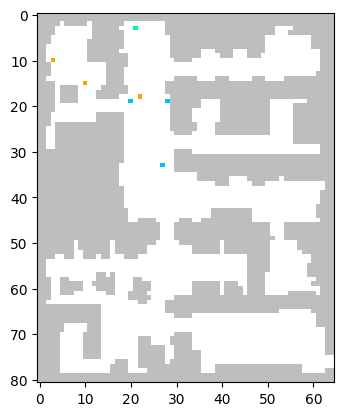

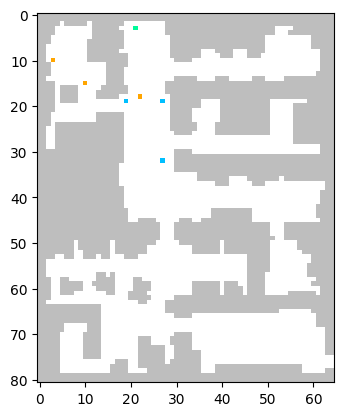

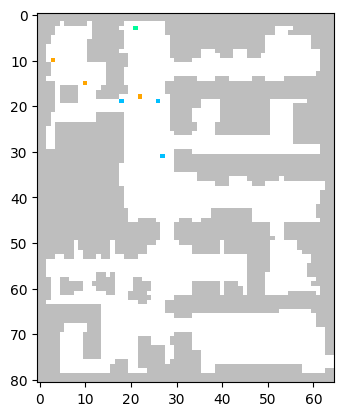

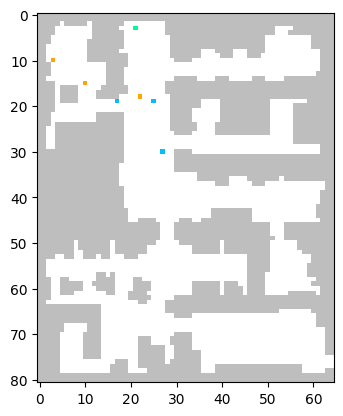

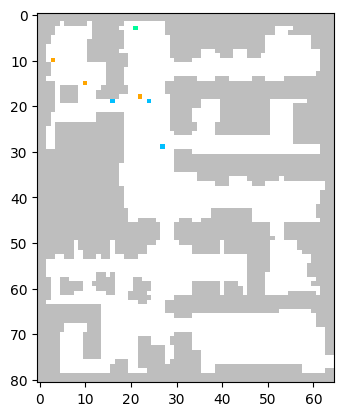

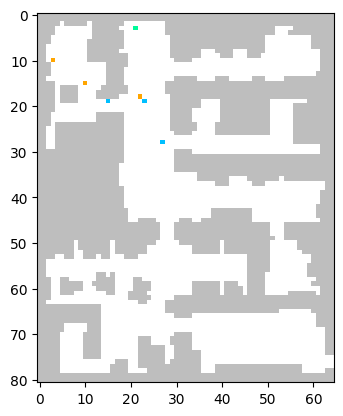

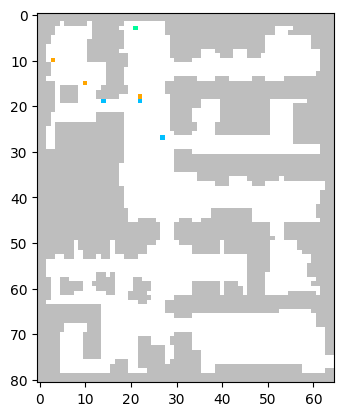

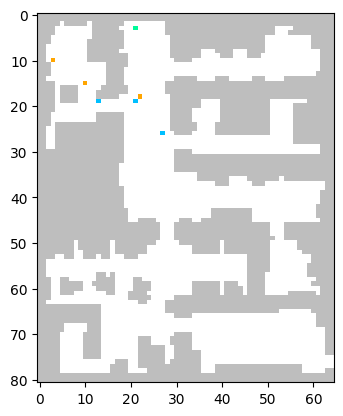

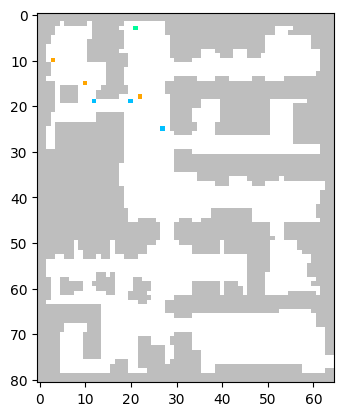

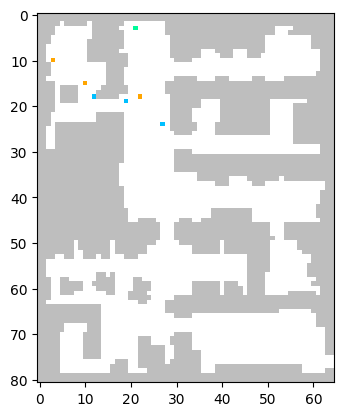

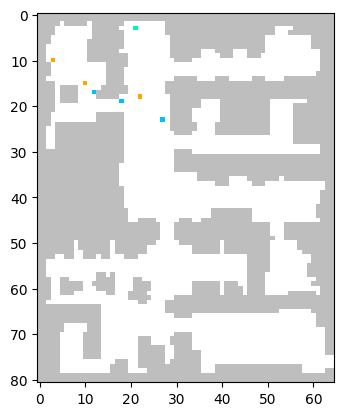

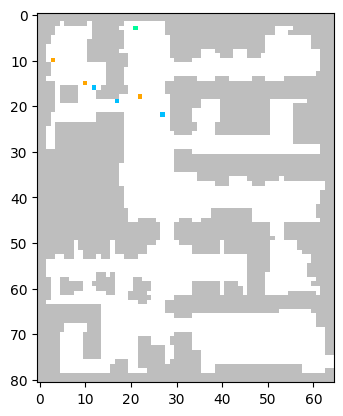

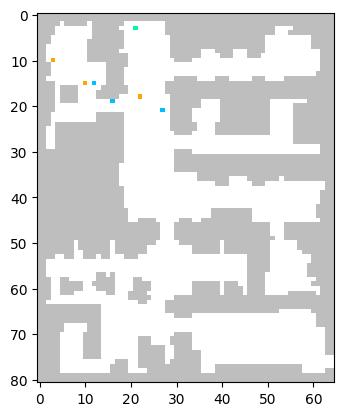

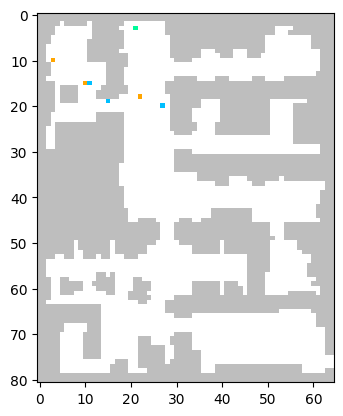

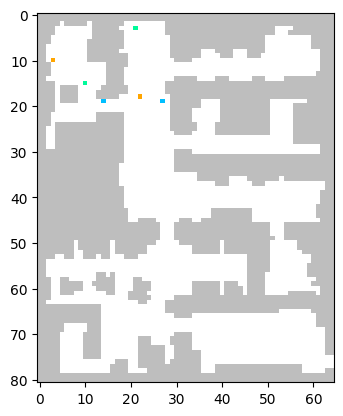

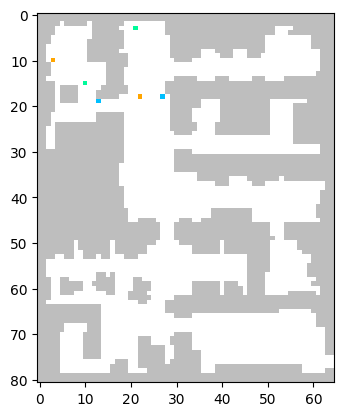

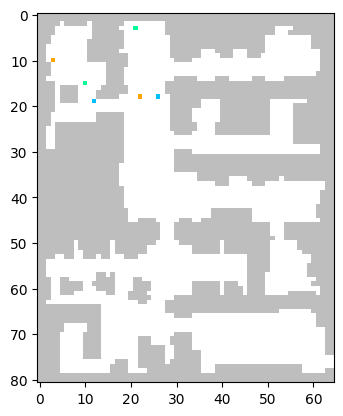

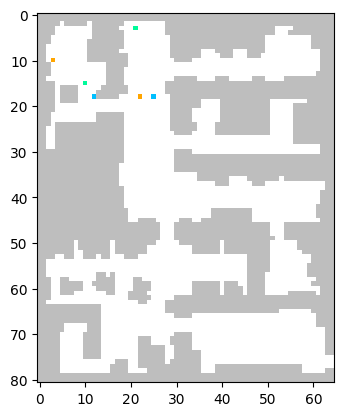

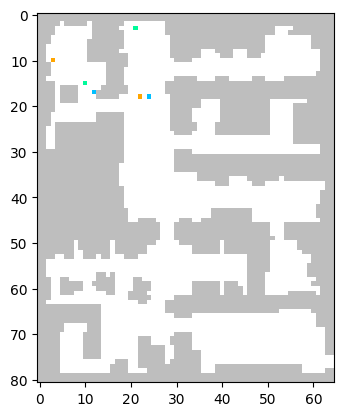

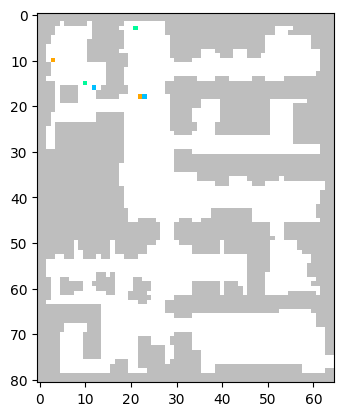

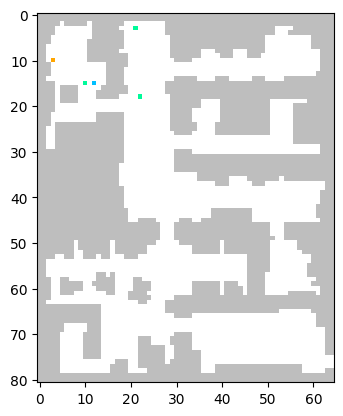

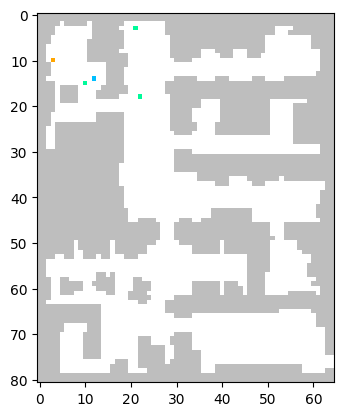

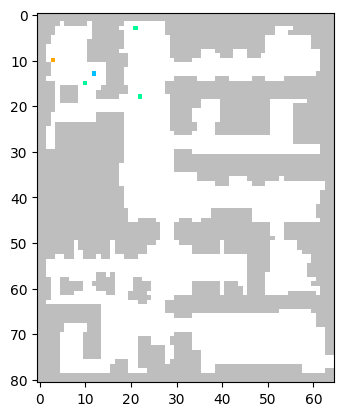

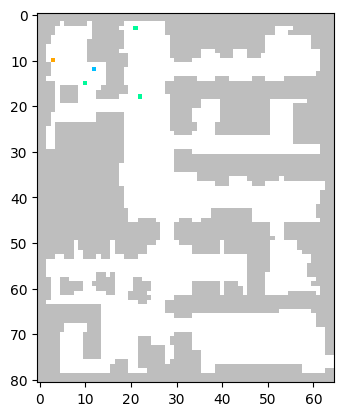

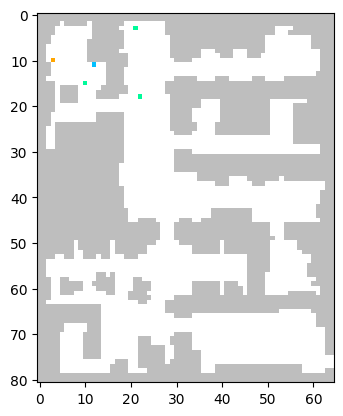

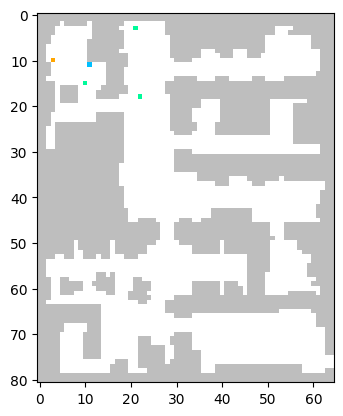

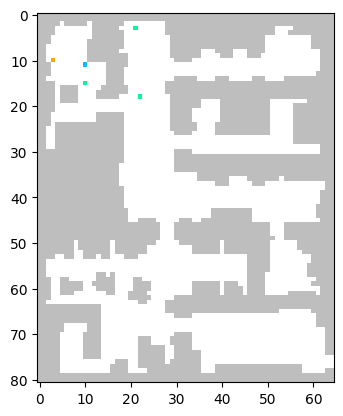

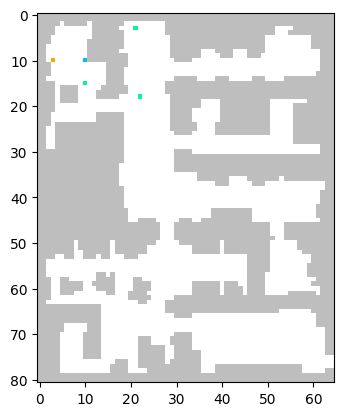

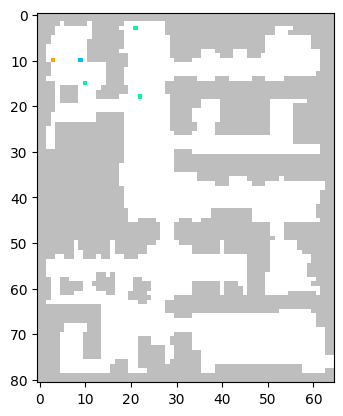

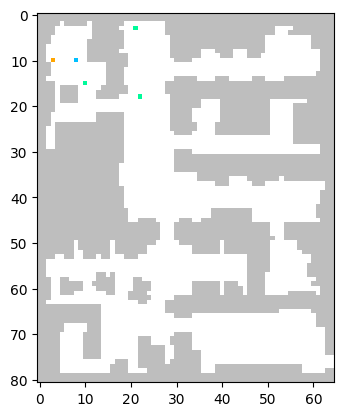

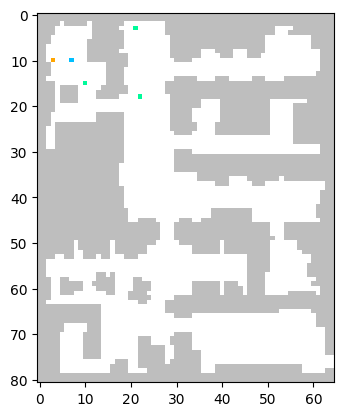

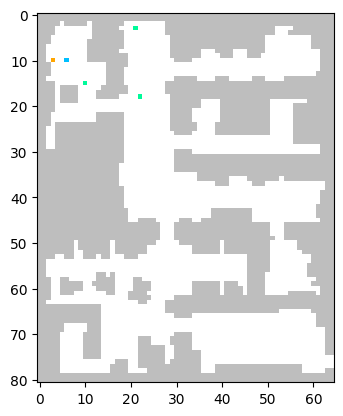

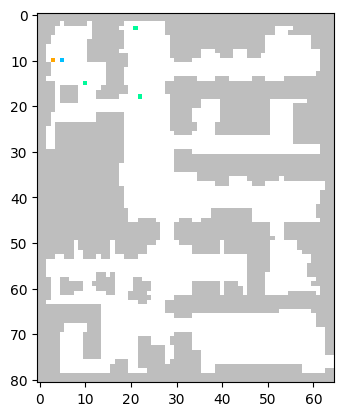

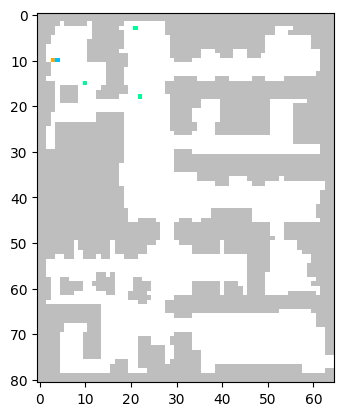

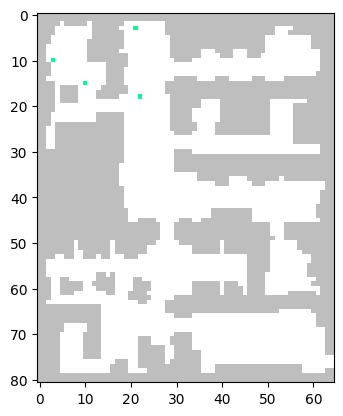

[23, 63, 77, 57]


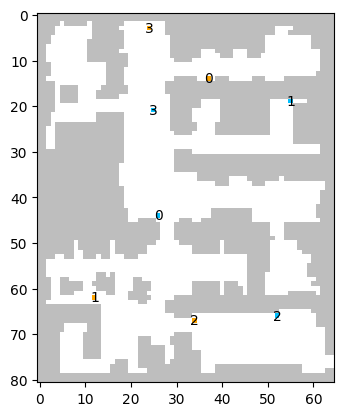

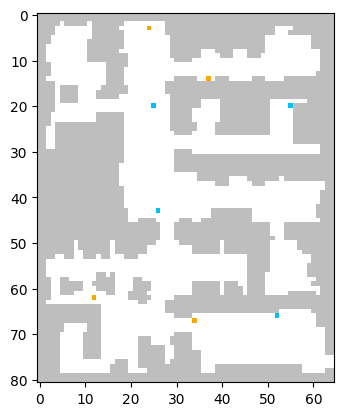

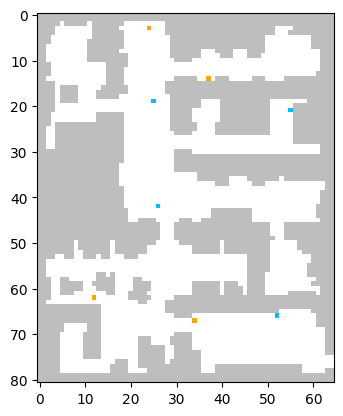

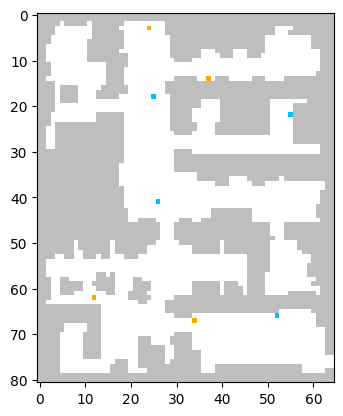

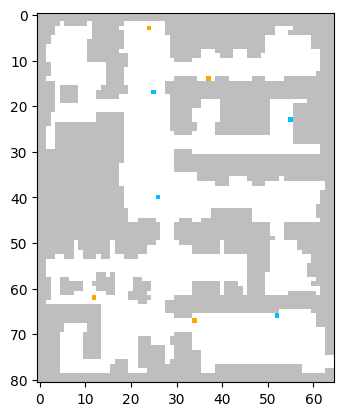

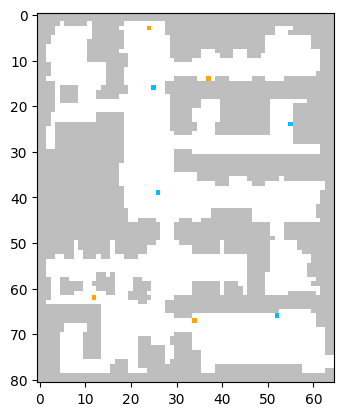

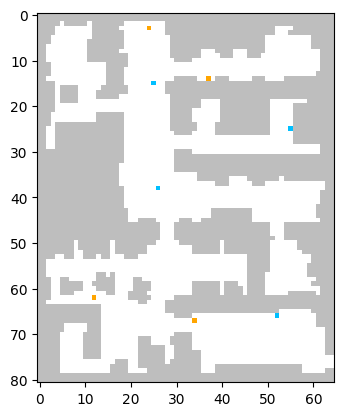

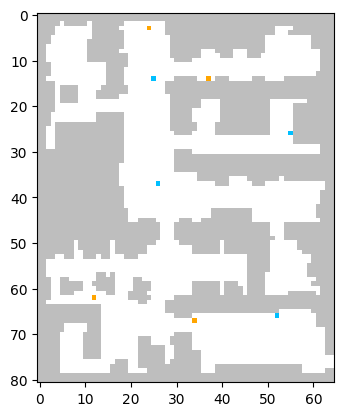

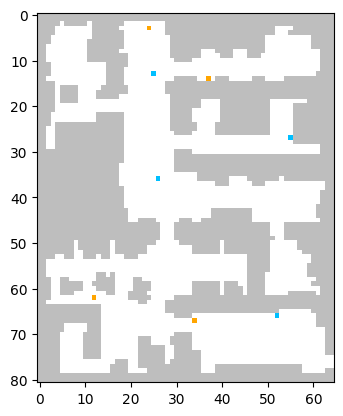

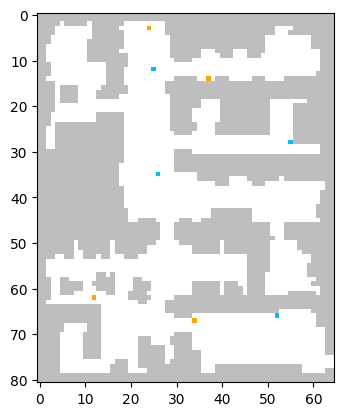

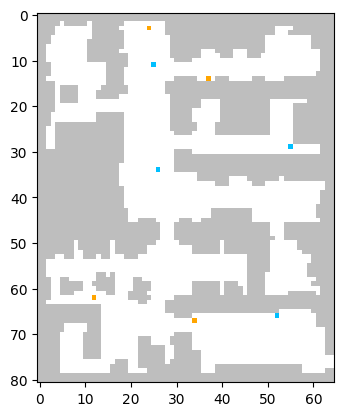

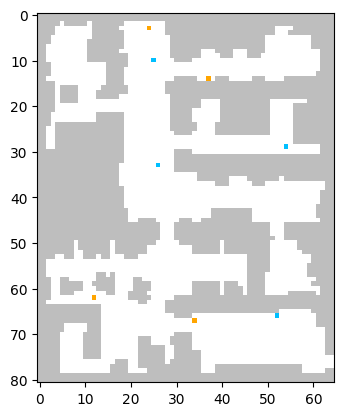

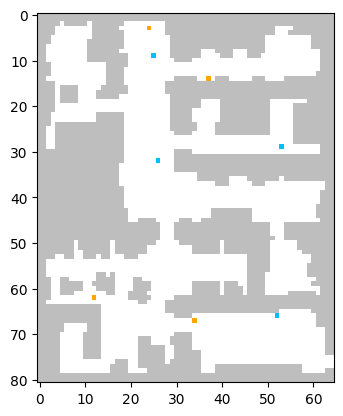

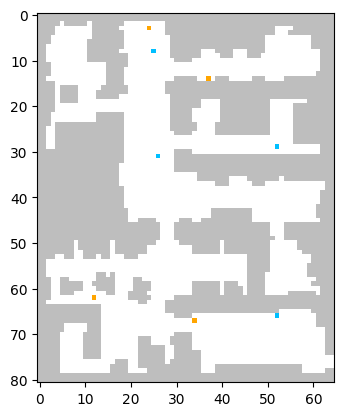

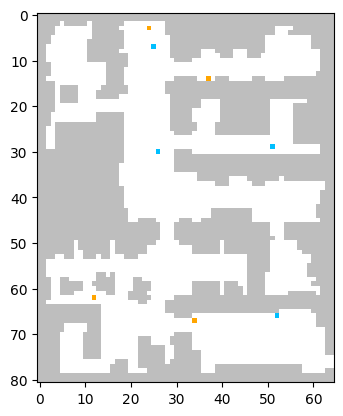

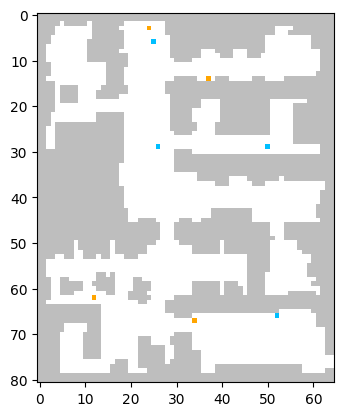

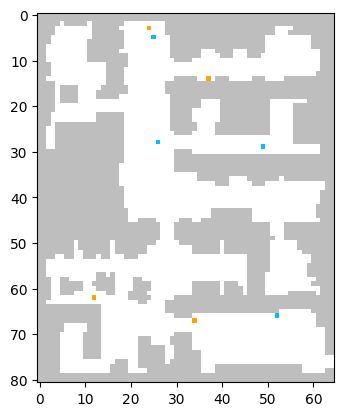

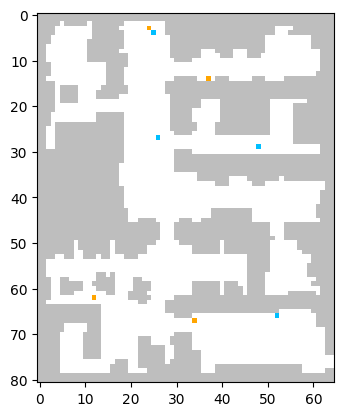

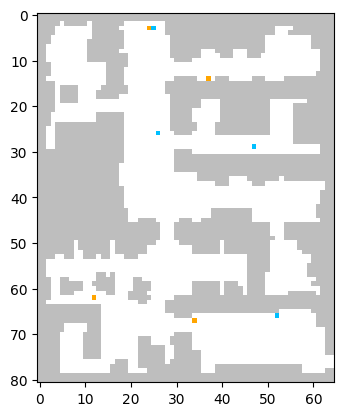

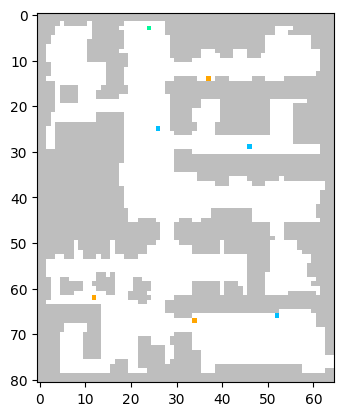

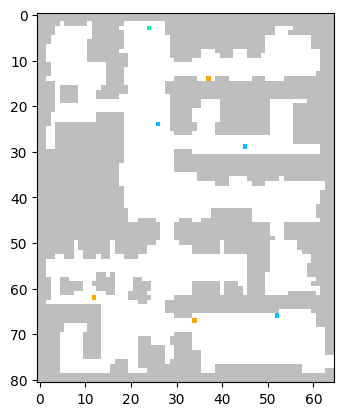

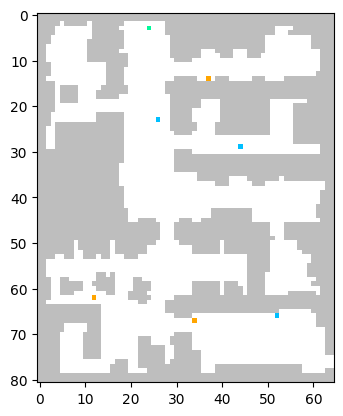

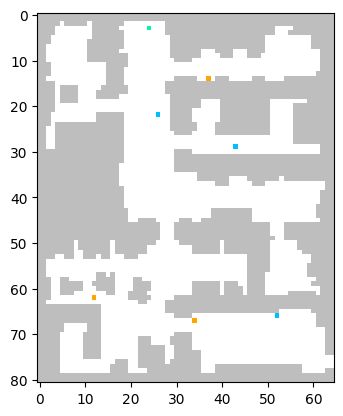

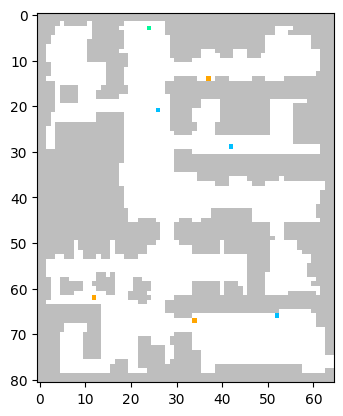

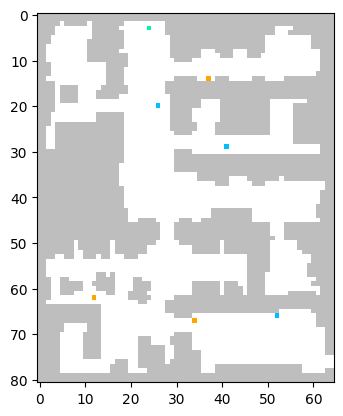

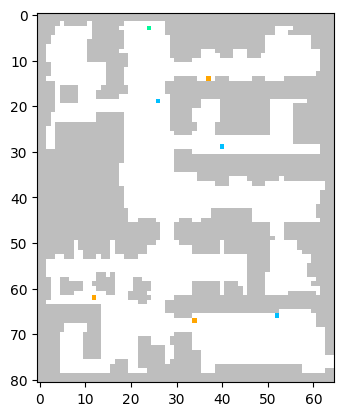

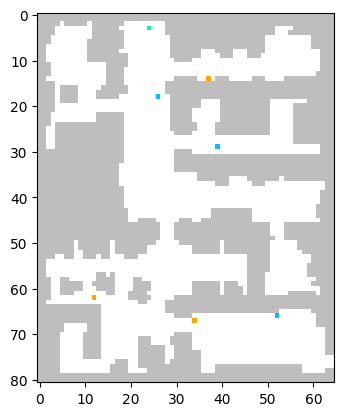

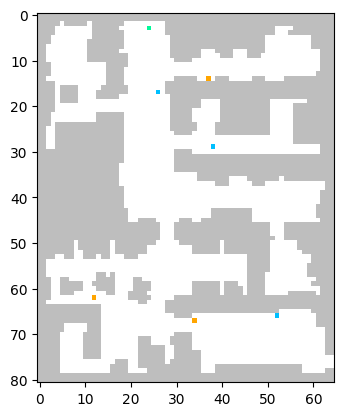

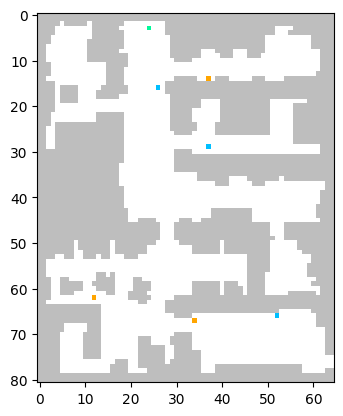

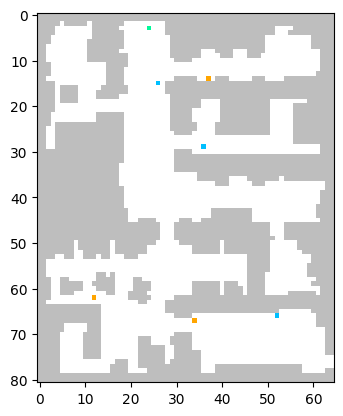

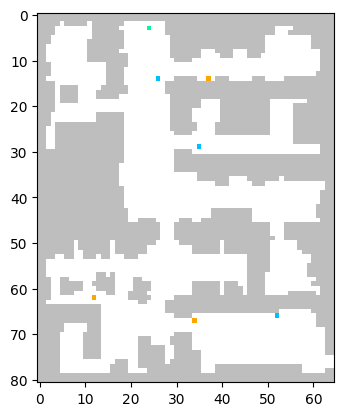

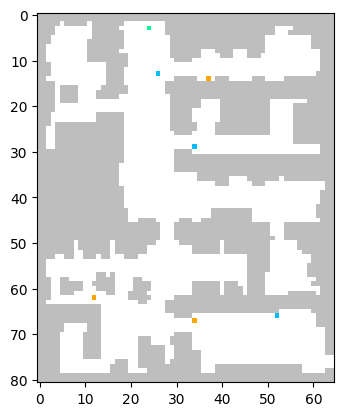

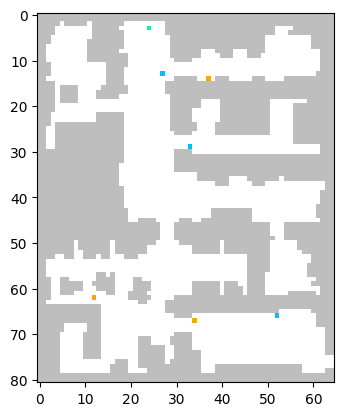

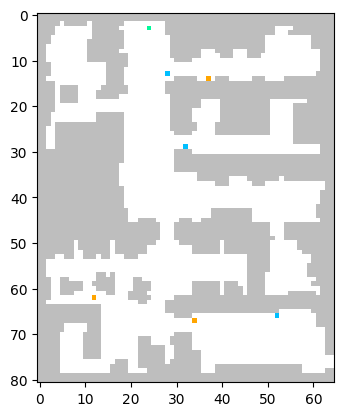

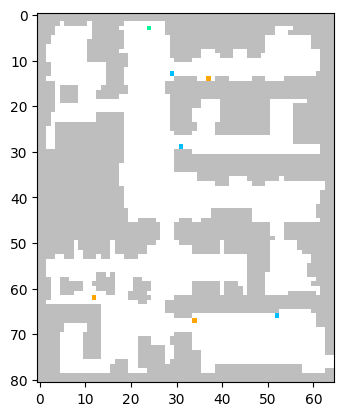

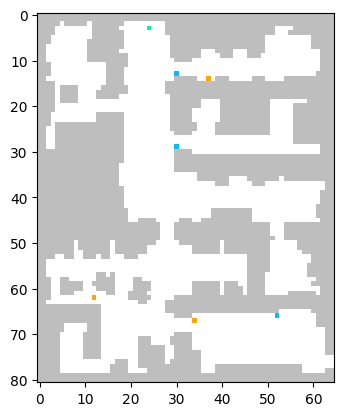

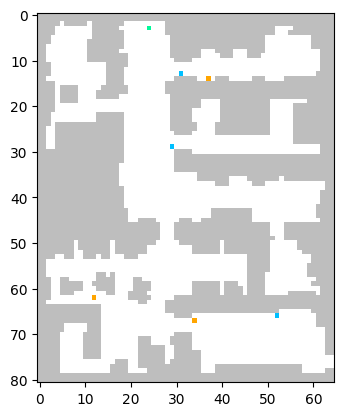

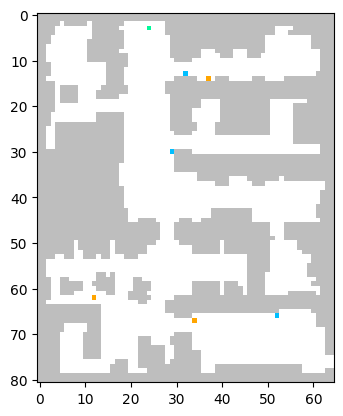

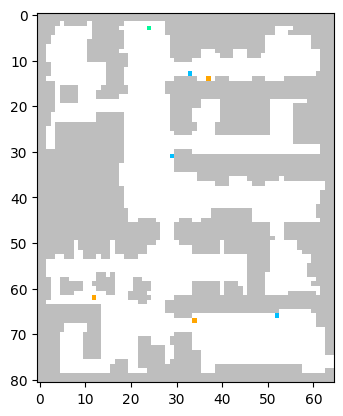

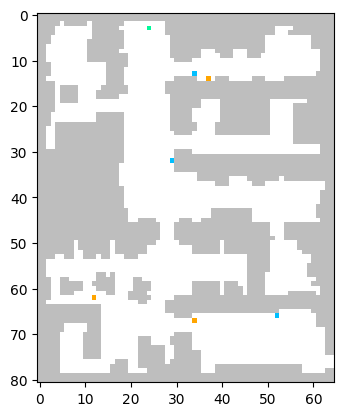

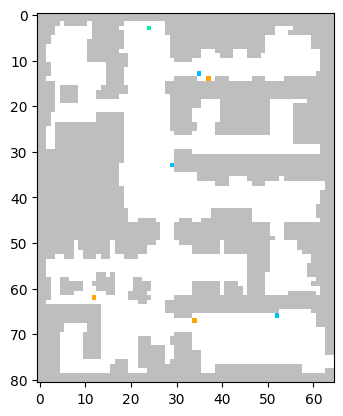

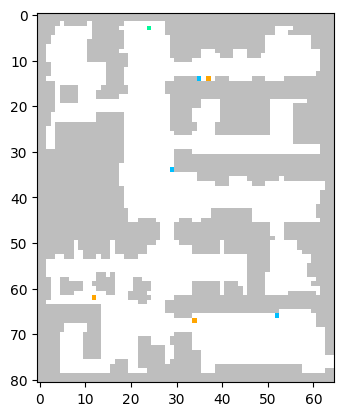

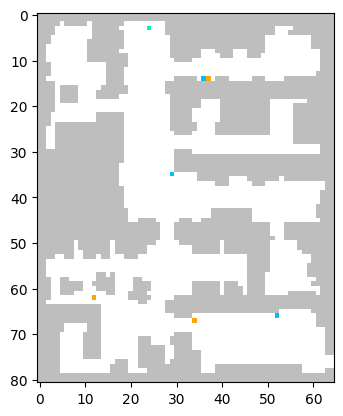

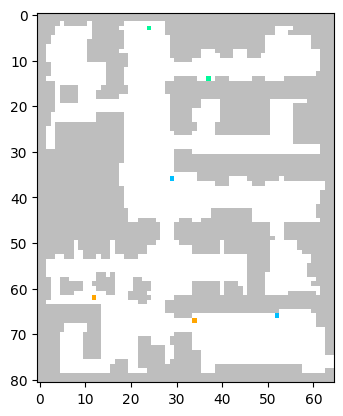

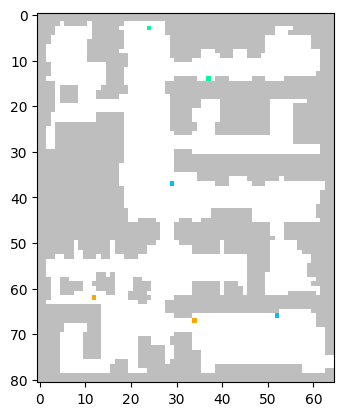

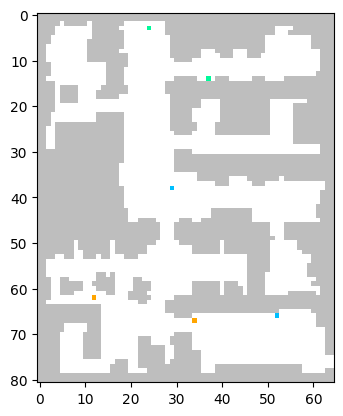

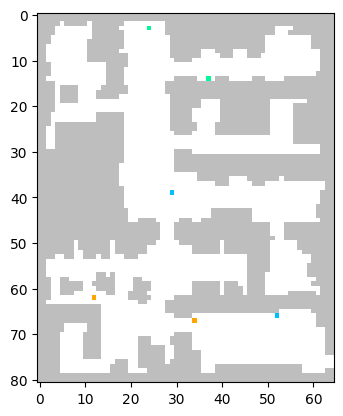

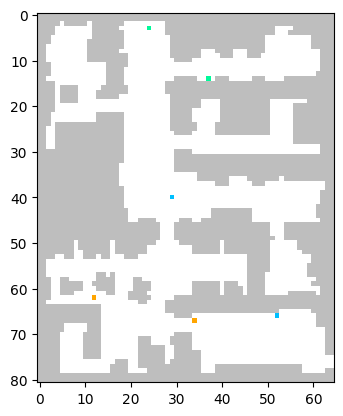

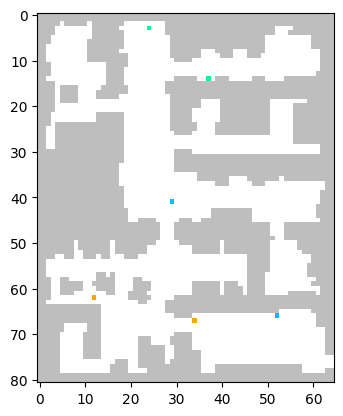

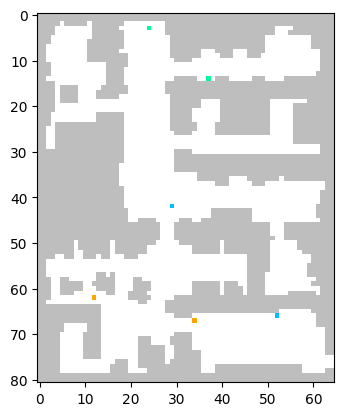

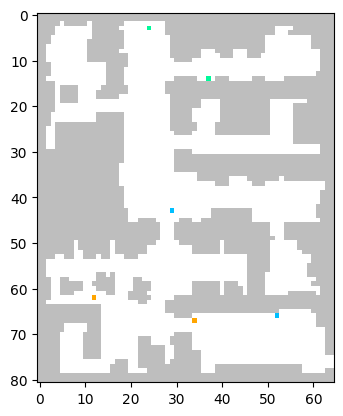

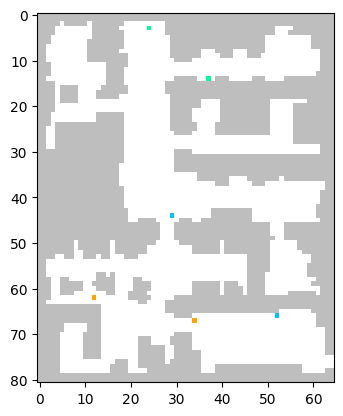

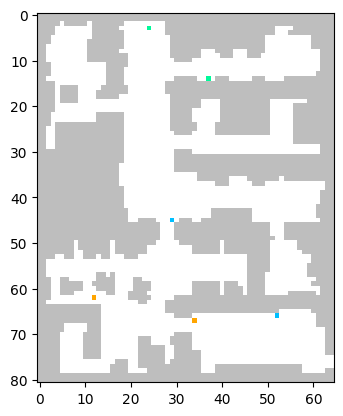

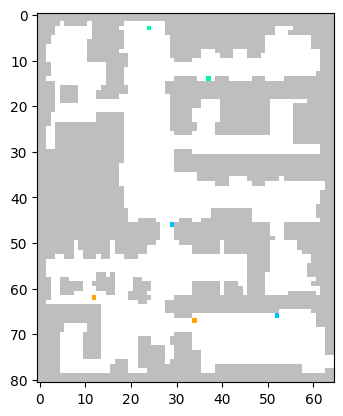

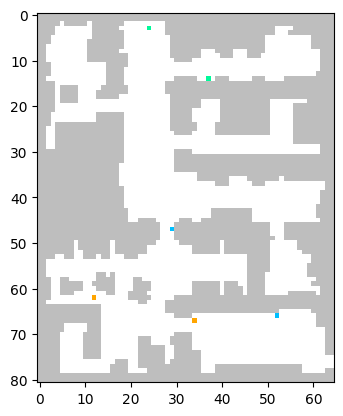

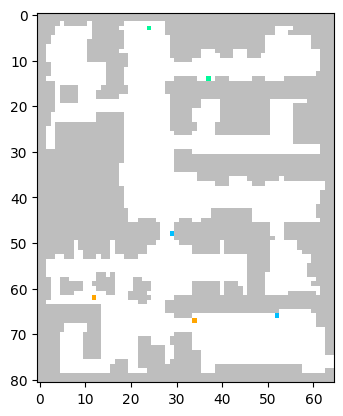

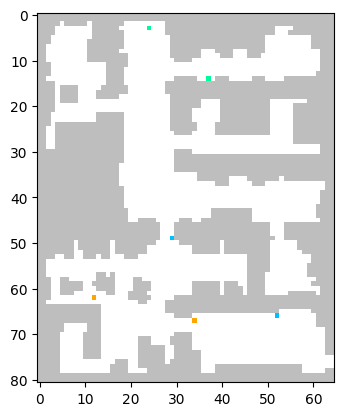

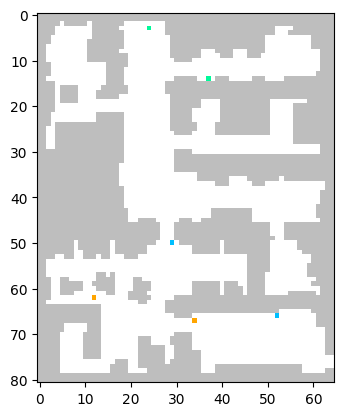

KeyboardInterrupt: 

In [7]:
all_step_lists = simulate_all_tests(tests[0:10], 512)

In [ ]:
all_step_lists = simulate_all_tests(tests[10:20], 512)

In [ ]:
all_step_lists = simulate_all_tests(tests[11:20], 512)